# BioSound Tutorial 3.  Reading a series of BioSound h5 files and calculating some summary statistics
### This notebook illustrates how to read BioSound objects that have been saved in h5 files and perform grouped averages and simple statistics

## Step 1. Loading all the dependencies.  
### numpy, matplotlib and soundsig should have been installed when you installed soundsig.  You might have to also install pandas.

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.sound import BioSound 

import os
import matplotlib.pyplot as plt


## Step 2. Specifying the location of the sound files in BioSound format (h5 files).

YOU WILL WANT TO CHANGE TO FOLLOWING CODE TO POINT TO THE RIGHT PLACE
You will also want to change the location for storing the pandas table.

In [2]:
# Go to the folder that has the h5 files corresponding to the BioSound objects.
os.chdir('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/cry_sequences_22babies/h5files')


tableStore = '/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/vocSelTableFull.h5'

In [3]:
# Read csv file with baby gender.
babyInfo = pd.read_csv('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/Banque_data_tous.csv', delimiter= ';', index_col = 0)

## Step 3. Looping through a set of bioSoundObjects to extract some features and storing them into a Pandas Data Frame.

In [4]:
# vocSelData is going to be a list of dictionary containing the values that we are going to extract from each BioSound object.
vocSelData = []

# Looping through all the files
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        
        # Allocate object and read data
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        
        # Take the time average formants 
        meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
        meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
        meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        
        # These are our three identifiers - the emitter (baby), the sex and the type of cry
        baby = myBioSound.emitter.tobytes().decode('UTF-8')
        sex = babyInfo.loc[baby]['sex']
        condition = myBioSound.type.tobytes().decode('UTF-8')

        

        # Get values for the fundamental
        if myBioSound.fund is not None:
            fund = float(myBioSound.fund)
            cvfund = float(myBioSound.cvfund)
            maxfund = float(myBioSound.maxfund)
            minfund = float(myBioSound.minfund)
            rangefund = np.nanstd(myBioSound.f0)
            rangefm = np.nanstd(np.abs(myBioSound.f0[1:]-myBioSound.f0[0:-1]))
        else:
            fund = None 
            cvfund = None
            maxfund = None
            minfund = None
            rangefund = None
            rangefm = None
            

        vocSelData.append({"WavFile": os.path.splitext(fname)[0], "Baby": baby, 'Sex': sex, 'Condition': condition, 
                     "fund": fund, "cvfund": cvfund, "maxfund": maxfund, "minfund": minfund,
                     "rangefund": rangefund, "rangefm": rangefm,
                     "F1": meanF1, "F2": meanF2, "F3":meanF3,
                     "sal": np.nanmean(myBioSound.sal), "rms": float(myBioSound.rms), 
                     "maxAmp": float(myBioSound.maxAmp),
                     "meanS": float(myBioSound.meanspect), "stdS": float(myBioSound.stdspect),
                     "skewS": float(myBioSound.skewspect), "kurtS": float(myBioSound.kurtosisspect), 
                     "entS": float(myBioSound.entropyspect),
                     "q1": float(myBioSound.q1), "q2": float(myBioSound.q2), "q3": float(myBioSound.q3),                  
                     "meanT": float(myBioSound.meantime), "stdT": float(myBioSound.stdtime),
                     "skewT": float(myBioSound.skewtime), "kurtT": float(myBioSound.kurtosistime),
                     "entT": float(myBioSound.entropytime)
})

# Make a panda data frame with all the data                    
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')   


/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/frederictheunissen/opt/anaconda3/envs/canary/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
vocSelTable.to_csv('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/vocSelTableFull.csv')


## Step 4. Calculate some summary statistics

In [5]:
vocSelTableGrouped = vocSelTable.groupby(['Condition'])
vocSelTableGroupedAgg = vocSelTableGrouped.aggregate('mean').reset_index()

vocSelTableGroupedAgg


<ipython-input-5-b11031e7b294>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vocSelTableGroupedAgg = vocSelTableGrouped.aggregate('mean').reset_index()


,Condition,fund,cvfund,maxfund,minfund,rangefund,rangefm,F1,F2,F3,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,B,500.192524,0.252073,1181.231964,314.688943,129.812366,35.120212,1447.045222,3371.615042,5330.287330,...,9.764824,0.736371,1468.172940,2025.426136,2954.833984,3.442087,1.609295,0.104921,2.280164,0.919938
1,D,538.782490,0.255177,1219.379244,319.019569,139.934043,35.432422,1510.881308,3294.516738,5175.641956,...,13.368839,0.715067,1408.956632,1946.797319,2730.801669,3.115829,1.499479,0.407520,3.119733,0.913184


In [23]:
vocSelTableGrouped = vocSelTable.groupby(['Sex'])
vocSelTableGroupedAgg = vocSelTableGrouped.aggregate('mean').reset_index()

vocSelTableGroupedAgg

,Sex,fund,cvfund,maxfund,minfund,rangefund,rangefm,F1,F2,F3,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,F,523.888883,0.270955,1214.400456,313.809078,146.738029,37.199033,1506.861348,3379.582724,5267.545588,...,11.157525,0.730958,1428.943359,1950.908203,2845.541016,3.329391,1.613833,0.260993,2.57478,0.915167
1,G,499.026812,0.233256,1169.332602,318.461552,117.693676,33.029412,1422.377256,3312.940020,5302.174081,...,10.560766,0.728557,1473.124426,2056.737563,2930.415614,3.355275,1.533233,0.128583,2.49847,0.920829


## Step 5. You can perform classical hypothesis testing at this point.  

For example, is the fundamental different in the two conditions and for boys and girls. Given that we have repeated measures per subject, we need to use mixed-effect models.  


In [6]:
# Mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Run LMER
md = smf.mixedlm('F1~ Condition*Sex', data=vocSelTable, groups=vocSelTable["Baby"], re_formula="~Condition")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())


                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        F1        
No. Observations:        286            Method:                    REML      
No. Groups:              22             Scale:                     47014.0655
Min. group size:         6              Log-Likelihood:            -1957.5518
Max. group size:         23             Converged:                 Yes       
Mean group size:         13.0                                                
-----------------------------------------------------------------------------
                             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------
Intercept                    1445.464   79.241 18.241 0.000 1290.154 1600.774
Condition[T.D]                111.500   49.454  2.255 0.024   14.571  208.429
Sex[T.G]                      -39.085  116.801 -0.335 0.738 -268.011  189.841
Condit

The mean fundamental is slightly different between the two conditions but not significant

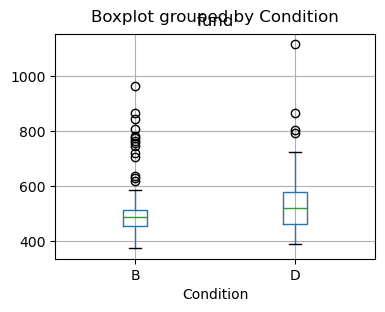

In [10]:
ax = vocSelTable.boxplot('fund', by='Condition', figsize=(4,3))
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/fundBoxPlot.eps')

In [11]:
# Repeat for saliency

# Run LMER
md = smf.mixedlm('sal ~ Condition*Sex', data=vocSelTable, groups=vocSelTable["Baby"], re_formula="~Condition")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      sal     
No. Observations:      286          Method:                  REML    
No. Groups:            22           Scale:                   0.0067  
Min. group size:       6            Log-Likelihood:          265.0901
Max. group size:       23           Converged:               Yes     
Mean group size:       13.0                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.903    0.019 48.285 0.000  0.867  0.940
Condition[T.D]             -0.097    0.029 -3.364 0.001 -0.153 -0.040
Sex[T.G]                    0.016    0.027  0.579 0.562 -0.038  0.069
Condition[T.D]:Sex[T.G]     0.060    0.042  1.414 0.157 -0.023  0.143
Group Var                   0.003   

/Users/frederictheunissen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


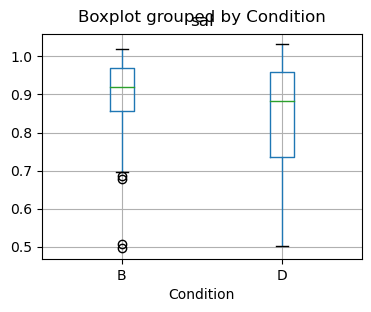

In [12]:
vocSelTable.boxplot('sal', by='Condition', figsize=(4,3))
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/salBoxPlot.eps')

In [13]:
# Repeat for meanS

# Run LMER
md = smf.mixedlm('meanS ~ Condition*Sex', data=vocSelTable, groups=vocSelTable["Baby"], re_formula="~Condition")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        meanS      
No. Observations:         286            Method:                    REML       
No. Groups:               22             Scale:                     225803.6918
Min. group size:          6              Log-Likelihood:            -2187.5069 
Max. group size:          23             Converged:                 Yes        
Mean group size:          13.0                                                 
-------------------------------------------------------------------------------
                              Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------
Intercept                     2225.062  198.479 11.211 0.000  1836.049 2614.075
Condition[T.D]                 126.565  164.027  0.772 0.440  -194.923  448.052
Sex[T.G]                       222.992  292.625  0.762 0.446 

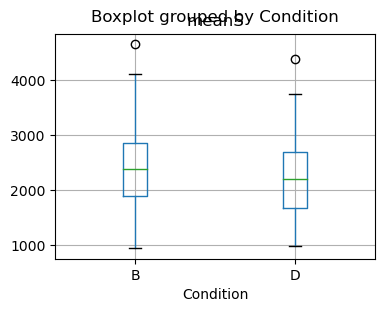

In [14]:
ax = vocSelTable.boxplot('meanS', by='Condition', figsize=(4,3))
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/meanSBoxPlot.eps')

In [15]:
vocSelTable

,WavFile,Baby,Sex,Condition,fund,cvfund,maxfund,minfund,F1,F2,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,CHM_B02,CHM,F,B,518.280554,0.515572,1253.611737,320.613551,2061.217017,4221.687142,...,3.213340,0.767703,2239.453125,2583.984375,4780.371094,1.861239,0.904420,2.176623,9.344494,0.872171
1,CAA_B06,CAA,F,B,407.143728,0.200324,1187.986877,300.078587,1494.457625,3362.782506,...,3.106723,0.774595,904.394531,1765.722656,3574.511719,2.617467,1.754827,1.250704,3.082811,0.916646
2,BEL_B08,BEL,F,B,466.960861,0.285750,1227.960931,301.184715,1343.672041,3251.912544,...,3.248689,0.798816,2153.320312,2971.582031,3574.511719,3.321960,1.042240,0.099923,3.566992,0.919871
3,ROM_D03,ROM,G,D,573.541376,0.309487,1498.764925,300.088249,1241.333547,3197.004327,...,15.759214,0.670905,1076.660156,1421.191406,1636.523438,3.080685,1.394531,0.180179,1.766425,0.920938
4,GRG_B03,GRG,G,B,708.037139,0.437332,1199.901708,305.653551,1234.788134,3076.907558,...,2.698426,0.742728,1076.660156,1937.988281,3359.179688,4.742266,1.594909,-0.817996,2.466932,0.930646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,AUP_D04,AUP,G,D,519.994333,0.087871,1093.615304,449.951341,1712.351316,2614.570888,...,17.089755,0.632657,1679.589844,2239.453125,2325.585938,1.726888,1.121750,1.750277,5.852215,0.893280
282,CAA_B11,CAA,F,B,400.568095,0.243046,1089.236079,301.074894,1321.223535,3206.574473,...,5.338270,0.800567,1248.925781,1981.054688,3100.781250,3.083785,2.119175,0.563141,1.686584,0.934110
283,FAE_D02,FAE,F,D,495.121096,0.412513,1242.223229,300.153053,1224.143122,2963.801692,...,11.787598,0.704754,1033.593750,1205.859375,1894.921875,3.438649,1.953688,-0.056998,1.516961,0.929050
284,AMJ_B09,AMJ,G,B,482.806211,0.175842,1026.356779,339.835628,1180.020655,3389.756814,...,4.396522,0.661473,1076.660156,2067.187500,2282.519531,2.793989,2.073908,0.771333,1.962585,0.917460
